In [20]:
import os
import pickle
import pandas as pd
from pathlib import Path
from pku_autonomous_driving import io, util, dataset, resnet, centernet, training, graphics, transform, const, geometry

import importlib
importlib.reload(geometry)
importlib.reload(io)
importlib.reload(util)
importlib.reload(dataset)
importlib.reload(resnet)
importlib.reload(centernet)
importlib.reload(training)
importlib.reload(graphics)
importlib.reload(transform)
importlib.reload(const)

<module 'pku_autonomous_driving.const' from '/root/pku-autonomous-driving/pku_autonomous_driving/const.py'>

In [12]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
import torchvision
from pku_autonomous_driving.transform import CropBottomHalf, CropFar, PadByMean, Resize, Normalize, DropPointsAtOutOfScreen, CreateMaskAndRegr, ToCHWOrder
from pku_autonomous_driving.const import IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE

near_transform = torchvision.transforms.Compose([
    CropBottomHalf(),
    #PadByMean(),
    Resize(IMG_WIDTH, IMG_HEIGHT),
    Normalize(),
    DropPointsAtOutOfScreen(IMG_WIDTH, IMG_HEIGHT),
    CreateMaskAndRegr(IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE),
    ToCHWOrder()
])

far_transform = torchvision.transforms.Compose([
    CropFar(IMG_WIDTH, IMG_HEIGHT),
    Normalize(),
    DropPointsAtOutOfScreen(IMG_WIDTH, IMG_HEIGHT),
    CreateMaskAndRegr(IMG_WIDTH, IMG_HEIGHT, MODEL_SCALE),
    ToCHWOrder()
])

transforms = {
    'NEAR': near_transform,
    'FAR': far_transform
}

train_transform = transforms[os.environ.get("TRANSFORM_TYPE", "NEAR")]

In [14]:
from pku_autonomous_driving.dataset import CarDataset, create_data_loader
from pku_autonomous_driving.const import BATCH_SIZE

train, dev = io.load_train_data()
train = train[:4]
dev = dev[:4]

train_dataset = CarDataset(train, transform=train_transform)
dev_dataset = CarDataset(dev, transform=train_transform)

train_loader = create_data_loader(train_dataset, batch_size=BATCH_SIZE)
dev_loader = create_data_loader(dev_dataset, batch_size=1)

float32


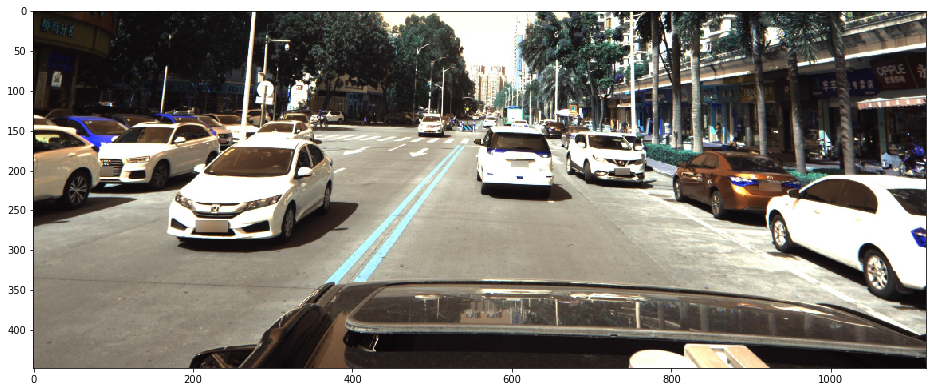

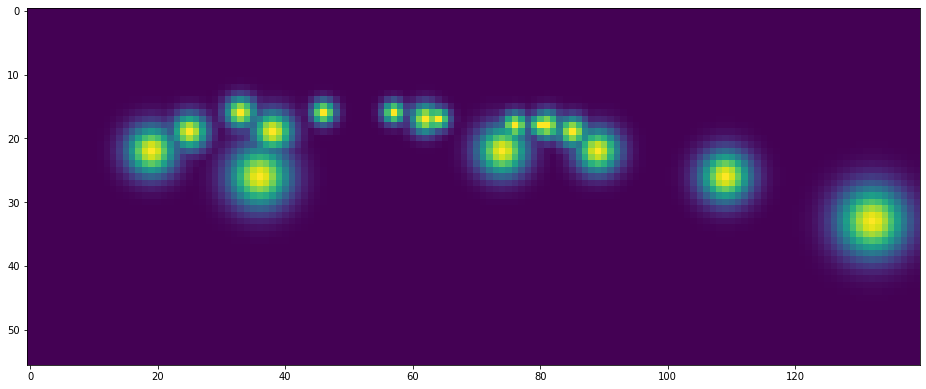

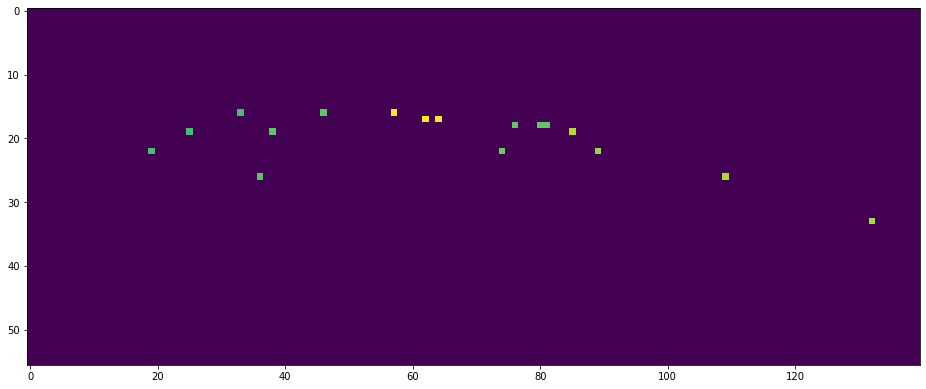

In [15]:
import matplotlib.pyplot as plt
import numpy as np

data = train_loader.dataset[0]
img, mask, regr = data["img"], data["mask"], data["regr"]
plt.figure(figsize=(16,16))
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(regr[-2])
plt.show()

In [16]:
mask.dtype

dtype('float32')

In [17]:
from torch import optim
from apex import amp

base_model = resnet.resnext50_32x4d(pretrained=False)
model = centernet.CentResnet(base_model, 8)

optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer =  RAdam(model.parameters(), lr = 0.001)

#os.environ["INITIAL_WEIGHTS"] = "./res_mask_1/checkpoint.pt"

setup_kwargs = {"model": model, "optimizer": optimizer, "device": device}
if 'INITIAL_WEIGHTS' in os.environ:
    setup_kwargs["path"] = Path(os.environ["INITIAL_WEIGHTS"])
model, optimizer = training.setup(**setup_kwargs)
print(setup_kwargs)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
{'model': CentResnet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, paddi

In [18]:
n_epochs = int(os.environ.get("N_EPOCHS", 6))
n_epochs = 1

try:
    history = pickle.load(Path(os.environ["INITIAL_HISTORY"]).open('rb'))
    beg_epoch = math.ceil(history.index[-1])
except:
    history = pd.DataFrame()
    beg_epoch = 0
end_epoch = beg_epoch + n_epochs

In [19]:
%%time
from torch.optim import lr_scheduler
import pandas as pd
import pickle

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

best_dev_loss = np.inf
for epoch in range(beg_epoch, end_epoch):
    training.clean_up()
    training.train(model, optimizer, exp_lr_scheduler, train_loader, epoch, device, history)
    training.evaluate(model, dev_loader, epoch, device, history)
    #training.save_checkpoint(model, optimizer, history)

    cur_dev_loss = history['dev_loss'].dropna().iloc[-1]
    #if cur_dev_loss < best_dev_loss:
    #    torch.save({"model": model.state_dict()}, './resnext50.pth')
    #    best_dev_loss = cur_dev_loss

float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32
float32


In [ ]:
history['train_loss'].iloc[:].plot();

In [ ]:
series1 = history.dropna()['mask_loss']
plt.plot(series1.index, series1 ,label = 'mask loss');
series2 = history.dropna()['regr_loss']
plt.plot(series2.index, 30*series2,label = 'regr loss');
series3 = history.dropna()['dev_loss']
plt.plot(series3.index, series3,label = 'dev loss');
plt.show()

In [ ]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

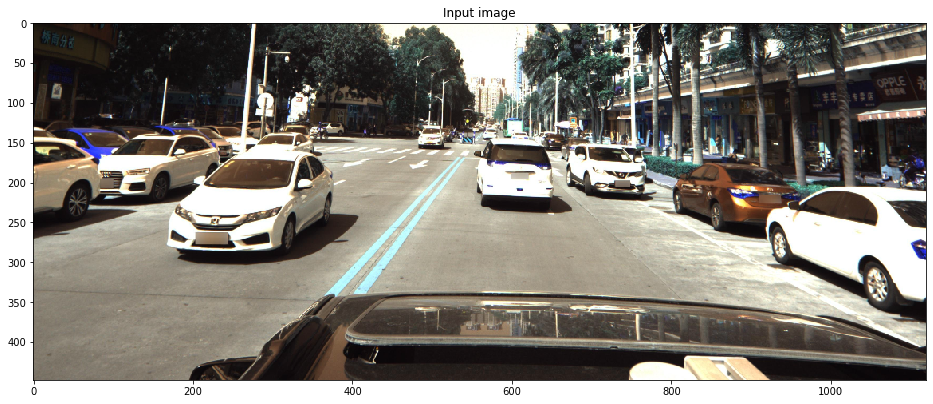

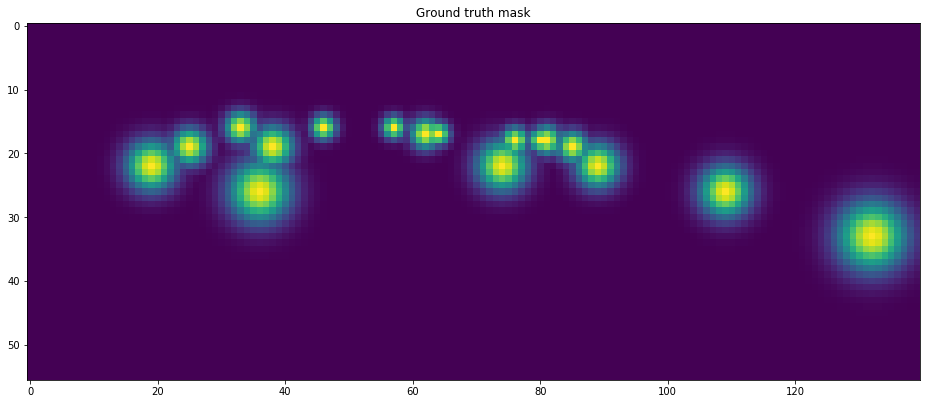

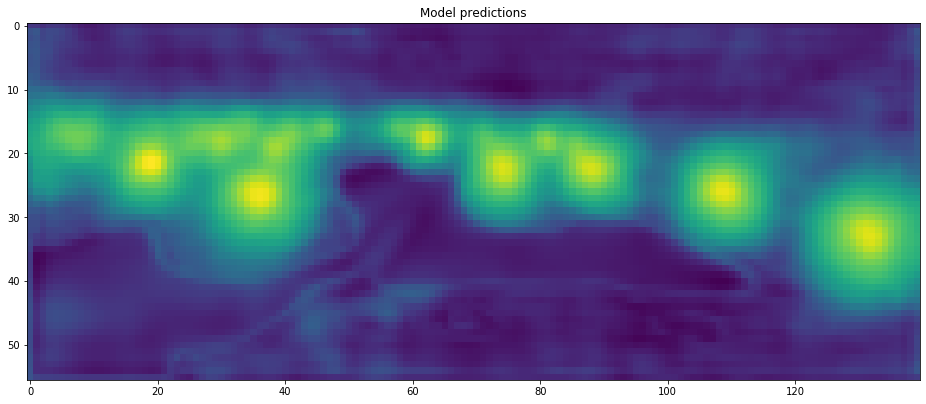

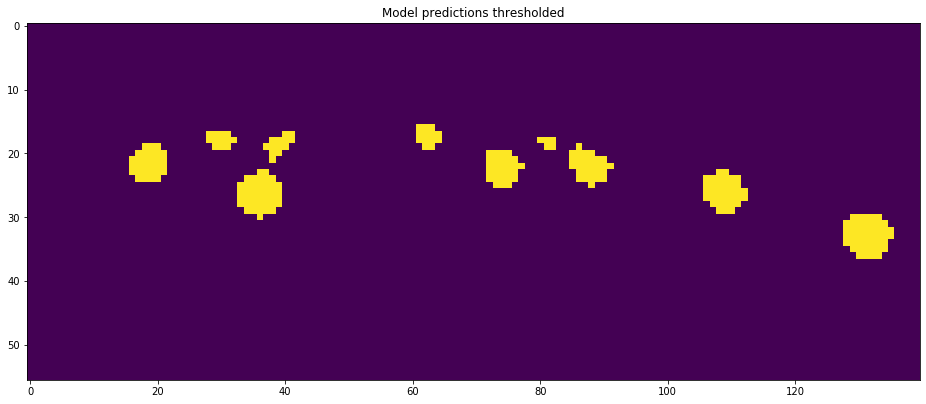

In [11]:
data = train_loader.dataset[0]
img, mask, regr = data["img"], data["mask"], data["regr"]

model.eval()

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(logits > 0)
plt.show()

[[ 17  70]
 [ 22  62]
 [ 24  91]
 [ 24 131]
 [ 25 132]]
17 70
{'pitch_cos': -0.00016784668, 'pitch_sin': 0.00024414062, 'roll': -3.1332766135507306, 'x': 0.0040740967, 'y': 0.0013198853, 'yaw': -0.0058059692, 'z': 0.0946044921875, 'pitch': 2.173083672929861}
{'pitch_cos': -0.00016784668, 'pitch_sin': 0.00024414062, 'roll': -3.1332766135507306, 'x': 0.004310637641083304, 'y': 0.01819675878276719, 'yaw': -0.0058059692, 'z': 0.0946044921875, 'pitch': 2.173083672929861, 'confidence': 0.7570766828437812}
22 62
{'pitch_cos': -0.0010070801, 'pitch_sin': -0.008758545, 'roll': 3.14056650002534, 'x': 0.0030975342, 'y': 0.0043907166, 'yaw': 0.0066375732, 'z': -0.542449951171875, 'pitch': -1.6852761593189811}
{'pitch_cos': -0.0010070801, 'pitch_sin': -0.008758545, 'roll': 3.14056650002534, 'x': 0.04725746637084938, 'y': -0.1208397644381064, 'yaw': 0.0066375732, 'z': -0.542449951171875, 'pitch': -1.6852761593189811, 'confidence': 0.8728901270007046}
24 91
{'pitch_cos': -0.0005340576, 'pitch_sin': -

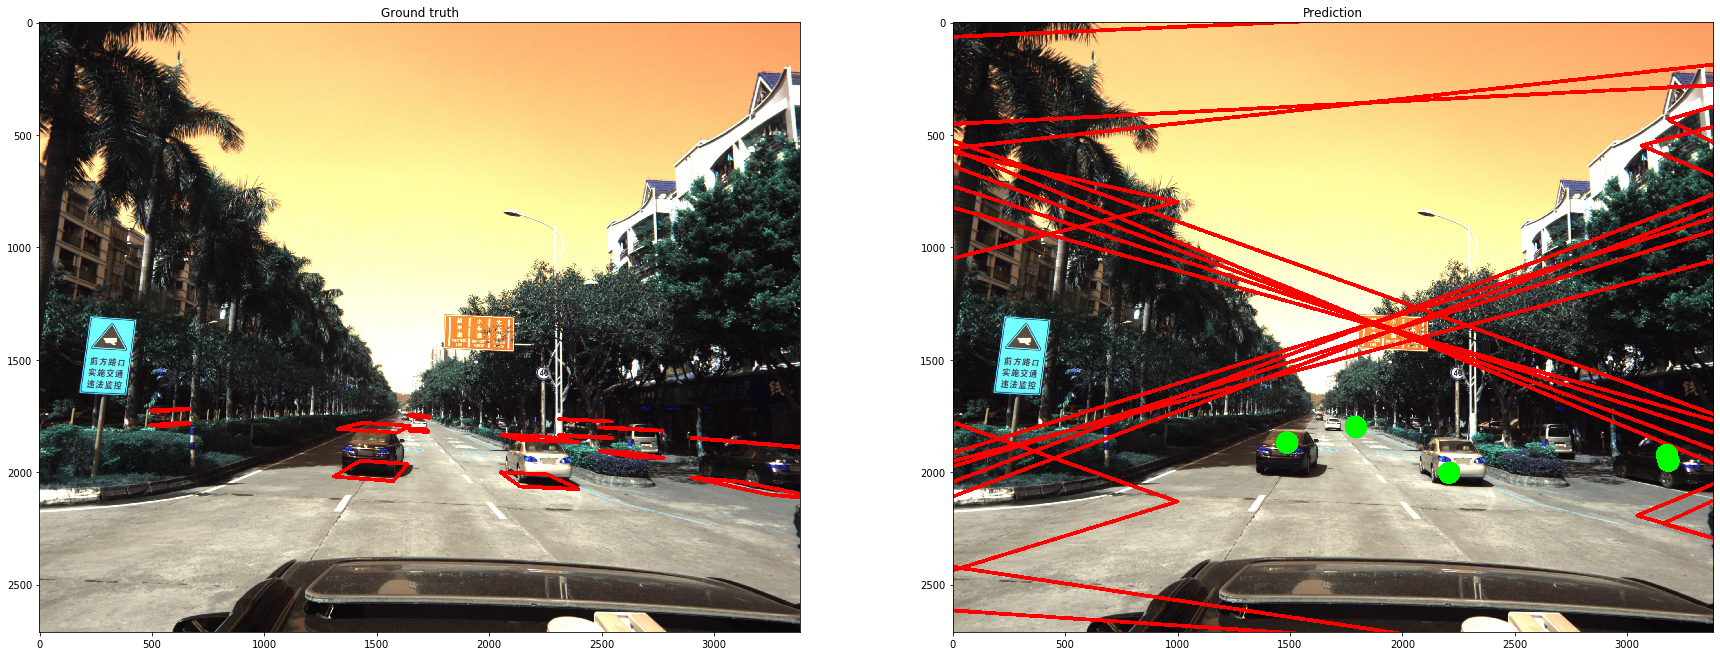

In [18]:
import gc
gc.collect()

training.clean_up()
for idx in range(1):
    data = dev_loader.dataset[idx]
    img, mask, regr = data["img"], data["mask"], data["regr"]
    output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()

    coords_pred = util.extract_coords(data, output[0])
    coords_true = util.extract_coords(data)

    img = io.load_image(dev_loader.dataset.dataset[idx].image_id)
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(graphics.draw_coords(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(graphics.draw_coords(img, coords_pred))
    plt.show()